# Dicoding - Proyek Akhir : Klasifikasi Gambar
Oleh: Putu Andika Tedja Permana  
Studi Kasus: Rock Paper Scissors

In [ ]:
!wget -q --no-check-certificate \
  https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip \
  -O /tmp/rockpaperscissors.zip

In [ ]:
!unzip -q /tmp/rockpaperscissors.zip

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

## Data Preparation

In [ ]:
root_dir = '/content/rockpaperscissors/rps-cv-images'

### Create dataframe
Nama file dan kategori dimasukkan ke dalam pandas dataframe. Tahapan ini akan  menghasilkan dataframe yang akan digunakan untuk train validation split nantinya.

In [ ]:
filenames = []
categories = []
for folder in [f for f in os.listdir(root_dir) if '.' not in f]:
    for filename in os.listdir(f'{root_dir}/{folder}'):
        filenames.append(f'{folder}/{filename}')
        categories.append(folder)

In [ ]:
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})
df

,filename,category
0,rock/RsBNa42PCliwNPQS.png,rock
1,rock/bqpOIN5gUl0r6vIS.png,rock
2,rock/9STiLxSOXvh5kjda.png,rock
3,rock/abNcCRBP8z4cNQco.png,rock
4,rock/pI8SGhRU1bmqZAcM.png,rock
...,...,...
2183,paper/qZX4Zcms0Ffpe8v7.png,paper
2184,paper/L2oIlMxDTToJYUvV.png,paper
2185,paper/UvFHqrnEwsrs6MgC.png,paper
2186,paper/aeVtGl2LQBr831P5.png,paper


### Split train validation

In [ ]:
train_df, validation_df = train_test_split(df, test_size=0.40, random_state=42)

In [ ]:
train_df = train_df.reset_index(drop=True)
validate_df = validation_df.reset_index(drop=True)

In [ ]:
Image_Width = 150
Image_Height = 150
Image_Size = (Image_Width,Image_Height)
Image_Channels = 3

In [ ]:
batch_size = 32

### Prepare image data generator

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=10,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    root_dir,
                                                    x_col='filename',
                                                    y_col='category',
                                                    target_size=Image_Size,
                                                    class_mode='categorical',
                                                    batch_size=batch_size,
                                                    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(validate_df, 
                                                              root_dir, 
                                                              x_col='filename',
                                                              y_col='category',
                                                              target_size=Image_Size,
                                                              class_mode='categorical',
                                                              batch_size=batch_size,
                                                              shuffle=True)

Found 1312 validated image filenames belonging to 3 classes.
Found 876 validated image filenames belonging to 3 classes.


## Modelling

In [ ]:
model = Sequential()

model.add(Conv2D(16, (3,3), activation='relu', input_shape=(Image_Width, Image_Height, Image_Channels), padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 64)       0

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
earlystop = EarlyStopping(patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

## Training Model

In [ ]:
epochs = 30
history = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=validation_generator,
                    validation_steps=validate_df.shape[0]//batch_size,
                    steps_per_epoch=train_df.shape[0]//batch_size,
                    callbacks=callbacks)

Epoch 1/30
41/41 [==============================] - 45s 1s/step - loss: 1.0776 - accuracy: 0.4314 - val_loss: 0.8558 - val_accuracy: 0.6030 - lr: 0.0010
Epoch 2/30
41/41 [==============================] - 43s 1s/step - loss: 0.8007 - accuracy: 0.6616 - val_loss: 0.6205 - val_accuracy: 0.7419 - lr: 0.0010
Epoch 3/30
41/41 [==============================] - 45s 1s/step - loss: 0.4310 - accuracy: 0.8354 - val_loss: 0.2892 - val_accuracy: 0.9051 - lr: 0.0010
Epoch 4/30
41/41 [==============================] - 42s 1s/step - loss: 0.2373 - accuracy: 0.9253 - val_loss: 0.1242 - val_accuracy: 0.9653 - lr: 0.0010
Epoch 5/30
41/41 [==============================] - 42s 1s/step - loss: 0.1664 - accuracy: 0.9451 - val_loss: 0.1100 - val_accuracy: 0.9630 - lr: 0.0010
Epoch 6/30
41/41 [==============================] - 42s 1s/step - loss: 0.1289 - accuracy: 0.9634 - val_loss: 0.1324 - val_accuracy: 0.9572 - lr: 0.0010
Epoch 7/30
41/41 [==============================] - 42s 1s/step - loss: 0.0979 - a

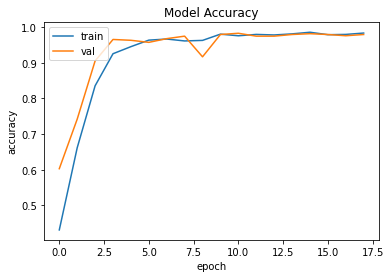

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

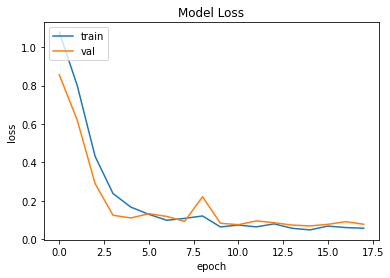

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Prediction

Saving 0Ug54ifXRqqlZS2Z.png to 0Ug54ifXRqqlZS2Z.png
Scissors


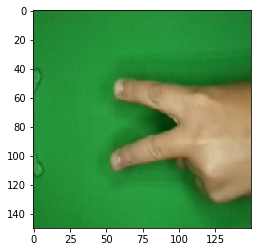

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():

    # predicting images
    path = fn
    img = image.load_img(path, target_size=Image_Size)

    imgplot = plt.imshow(img)
    x = image.img_to_array(img)
    x = np.expand_dims(x*255, axis=0)
    images = np.vstack([x])

    classes = model.predict(images)  
    if np.argmax(classes) == 0:
        print('Paper')
    elif np.argmax(classes) == 1:
        print('Rock');
    elif np.argmax(classes) == 2:
        print('Scissors')
    else:
        print('Unknown')

In [ ]:
train_generator.class_indices

{'paper': 0, 'rock': 1, 'scissors': 2}